<div>
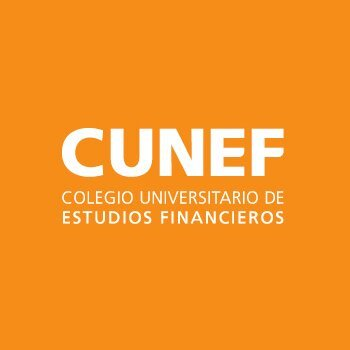
</div>

# **Turismo en España**
En este notebook se mostrará la serie temporal del **número de turistas en España** y observaremos cómo afectó ésta frente al COVID-19. 

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías utilizadas*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


## *2) Lectura del csv y preprocesado de los datos*

Se procede a la lectura del CSV del tráfico de turistas en España.
- Fuente: https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176996&menu=ultiDatos&idp=1254735576863

In [62]:
df = pd.read_csv("turismo.csv", delimiter=";")

# Se selecciona el total y nacional
df_turismo = df.iloc[0:76, 2:5]

# Convertimos en formato fecha
df_turismo['Periodo'] = df_turismo['Periodo'].str.replace('M', '') # para erradicar la M
df_turismo['Periodo'] = pd.to_datetime(df_turismo['Periodo'], format='%Y%m')

# Creamos índice = fecha
df_turismo = df_turismo.set_index("Periodo")

# función astype a float
df_turismo['Total']=df_turismo['Total'].str.replace('.', '').astype(float)
df_turismo.dtypes

# Poner al revés el df
df_turismo=df_turismo.iloc[::-1]
df_turismo

,Total
Periodo,
2016-03-01,4627206.0
2016-04-01,6086327.0
2016-05-01,7111154.0
2016-06-01,7552758.0
2016-07-01,9545792.0
...,...
2022-02-01,3156809.0
2022-03-01,4032127.0
2022-04-01,6102142.0


Chequeamos posibles valores faltantes en 'Total', en el caso de que los haya los rellenaríamos aplicando una media o bien aplicando el dato del mes anterior. 

In [10]:
df_turismo.isnull().sum()

Total    0
dtype: int64

No hay errores en los periodos observados, por lo que vamos a proceder a la realización del análisis exploratorio mediante gráficos y cálculos estadísticos. Pero antes vamos a realizar un rename de las columnas con el formato necesario para algunos modelos como el Prophet:

## *3) EDA*



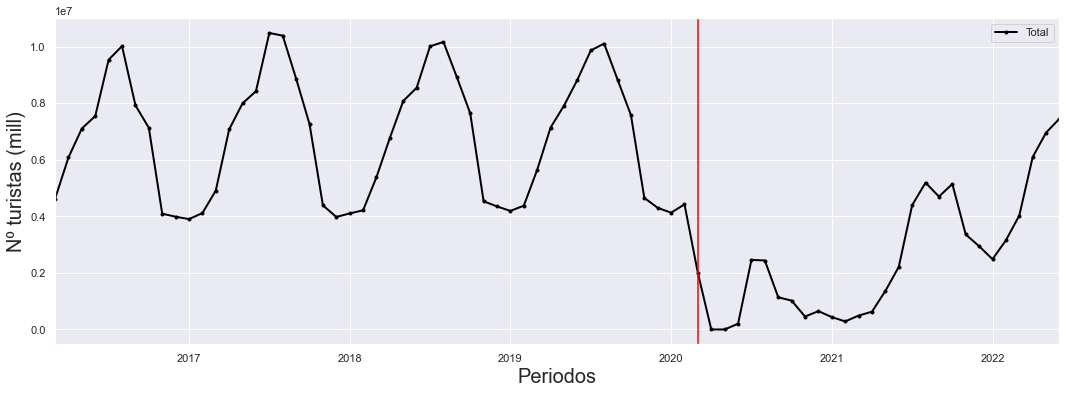

In [11]:
sns.set(rc={'figure.figsize':(18, 6)})
fig = df_turismo.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_ylabel('Nº turistas (mill)', fontsize =20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodos', fontsize = 20);
# fig.figure.savefig('../pics/df_turismo/tendencia.png');

Como era de esperar, el turismo tiene una estacionalidad bastante clara habiendo máximos en los meses de verano y mínimos en la època de Navidad. Cuando llega la época del COVID, el turismo se desploma y ahora va recuperándose poco a poco con la ayuda de las estacionalidad, donde ya se ven pequeños máximos en el verano del 2021.


A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición
Para que no nos afecte al análisis la situación anómala provocada por COVID-19, **analizaremos sólamente hasta el último mes antes del inicio de la pandemia**, esto es, **el mes de febrero del 2020**.

In [12]:
df_turismo_eda=df_turismo.iloc[:48,:]
df_turismo_eda.tail()

,Total
Periodo,
2019-10-01,7587749.0
2019-11-01,4655021.0
2019-12-01,4304741.0
2020-01-01,4133024.0
2020-02-01,4427344.0


### 3.1) Cálculo de la media y de la varianza

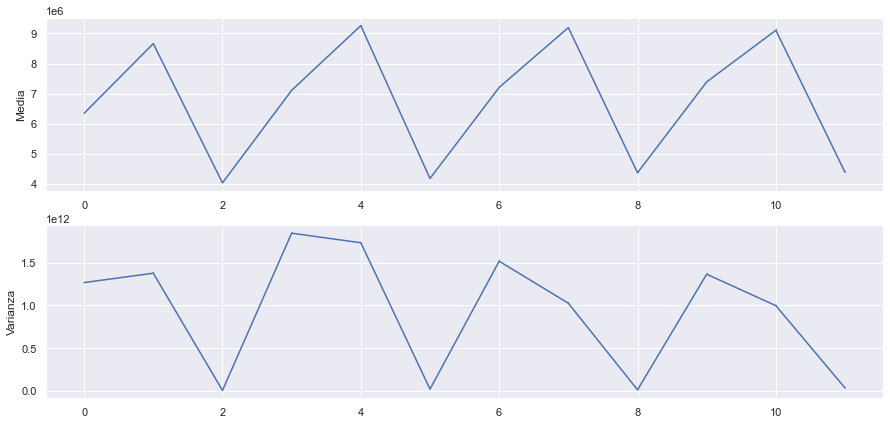

In [63]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

media = split_and_summarize(df_turismo_eda, 'Total', 4, np.mean)

varianza = split_and_summarize(df_turismo_eda, 'Total', 4, np.var)

cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()
fig.figure.savefig('../pics/df_turismo/meanvariance.png')

A simple vista no puedo determinar si nuestra serie es o no estacionaria, por tanto realizo la prueba de Dickey fuller aumentada.

### 3.2) Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [15]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_turismo_eda)

Results of Dickey-Fuller Test:
Test Statistic                 -2.557108
p-value                         0.102190
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


<u>La serie temporal NO es estacionaria</u>, debido a que el p-value del test Dickey-Fuller es mayor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

Además, vemos que nuestro test estadístico (-2.5571) es mayor que los umbrales de significancia del 1%, 5% y 10%, lo que nos da más indicios de que es una serie que posee alguna estructura dependiente del tiempo.

### 3.3) Gráficas del comportamiento mensual 

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

Text(0.5, 1.0, 'Comportamiento mensual')

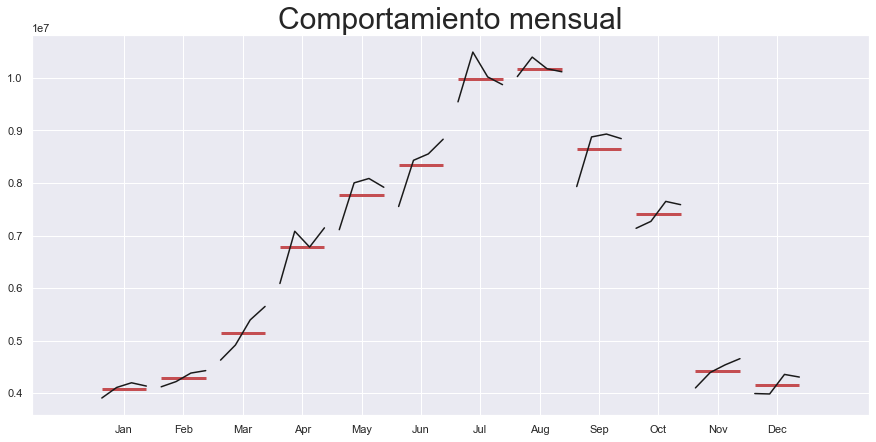

In [16]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_turismo_eda['Total'],ax=ax)
ax.set_title('Comportamiento mensual', fontsize = 30)
# ax.figure.savefig('../pics/df_turismo/monthbehavior.png')

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

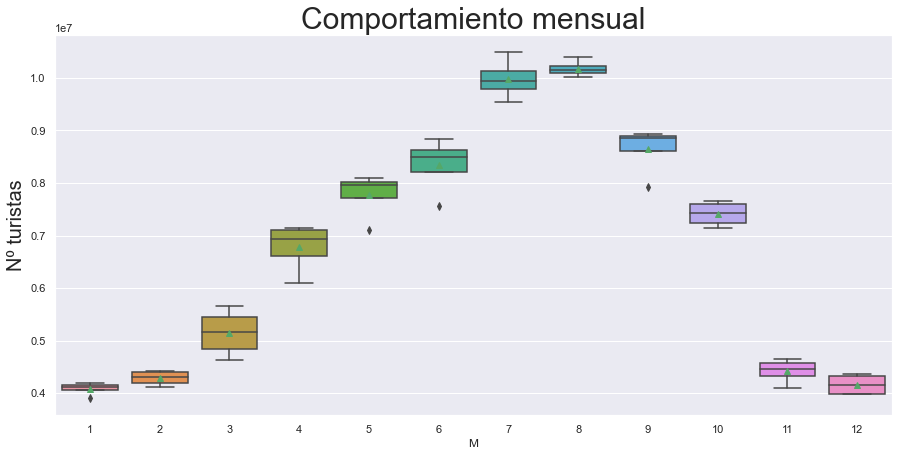

In [17]:
df_turismo_eda['M'] = df_turismo_eda.index.month
sns.boxplot(data = df_turismo_eda, x = 'M', y='Total', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Nº turistas', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_turismo/boxplotmonth.png')

Como es de esperar, el turismo en España tiene sus meses fuertes en la estación del verano, por lo que confirmamos que hay una estacionalidad.

### 3.4) Descomposición

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

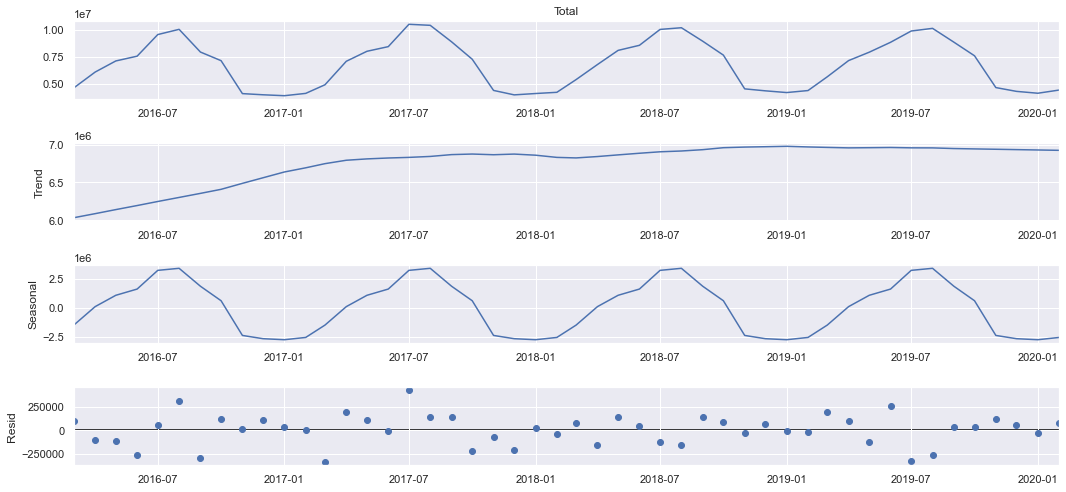

In [18]:
desglose = seasonal_decompose(df_turismo_eda['Total'], 
                                   model='additive',
                                   filt=None, 
                                   period=12,
                                   two_sided=True,
                                   extrapolate_trend=1);
desglose.plot();
# plt.savefig('../pics/df_turismo/decompose.png')

Una vez llegados hasta aquí, podemos concluir que:
- La serie **NO es estacionaria**
- **Tiene una estacionalidad** marcada en la época del verano.
- Que la tendencia era creciente hasta la época del COVID-19, donde se vuelve decreciente hasta principios del 2021 en el que vuelve a recuperar la tendencia que tenía anteriormente.

## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)

A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta junio del 2022, hay 28 meses para el test_size.



Cantidad de períodos en Train: 48
Cantidad de períodos en Test: 28


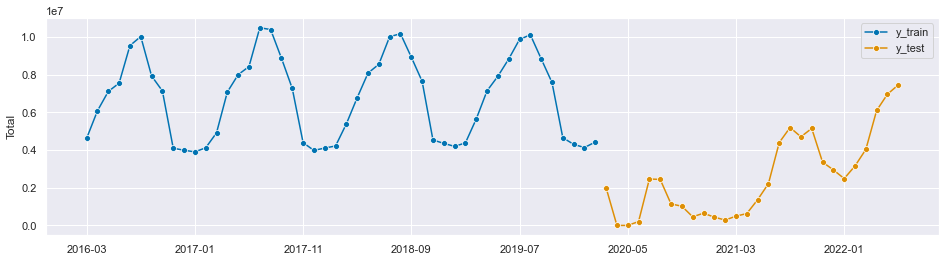

In [19]:
#Train-test
y_train, y_test = temporal_train_test_split(y = df_turismo['Total'].astype('float64').to_period('M'), 
                                            test_size=28)
#Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0]);

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [64]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
turismo_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

turismo_auto_ets.fit(y_train)
turismo_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   48
Model:                       ETS(MNM)   Log Likelihood                -677.642
Date:                Mon, 05 Sep 2022   AIC                           1387.284
Time:                        19:15:31   BIC                           1417.223
Sample:                    03-31-2016   HQIC                          1398.598
                         - 02-29-2020   Scale                            0.003
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4073      0.182      2.238      0.025       0.051       0.764
smoothing_seasonal      0.5926      0.317      1.871      0.061      -0.028       1.213
initial_level        6.328e+06        nan        nan        nan         nan         nan
initial_seasonal.0      0.6794        nan        nan        nan         nan         nan
initial_seasonal.1      0.6499        nan        nan        nan         nan         nan
initial_seasonal.2      0.6606        nan        nan        nan         nan         nan
initial_seasonal.3      0.6940      0.016     43.867      0.000       0.663       0.725
initial_seasonal.4      1.2046        nan        nan        nan         nan         nan
initial_seasonal.5      1.3786      0.040     34.486      0.000       1.300       1.457
initial_seasonal.6      1.7070        nan        nan        nan         nan         nan
initial_seasonal.7      1.6281        nan        nan        nan         nan         nan
initial_seasonal.8      1.3068        nan        nan        nan         nan         nan
initial_seasonal.9      1.2467        nan        nan        nan         nan         nan
initial_seasonal.10     1.0876      0.021     50.635      0.000       1.046       1.130
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                        2.17   Jarque-Bera (JB):               445.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 5.19e+14. Standard errors may be unstable.
"""

In [65]:
#step 5: querying predictions
turismo_pred = turismo_auto_ets.predict(fh=list(fh))
turismo_pred.round().tail()

2022-02    4427339.0
2022-03    5567266.0
2022-04    7037309.0
2022-05    7993546.0
2022-06    8820595.0
Freq: M, dtype: float64

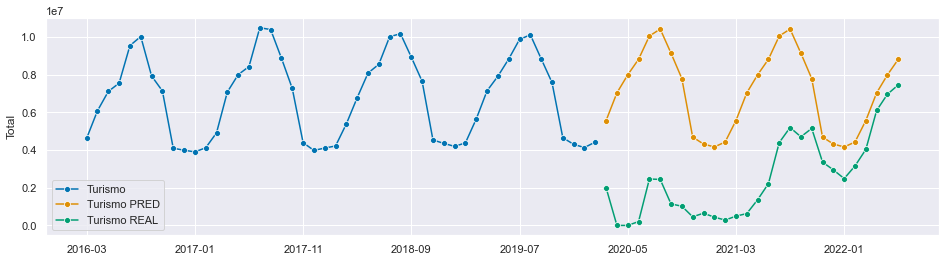

In [24]:
# optional: plotting predictions and past data
plot_series(y_train, turismo_pred, y_test, labels=["Turismo", "Turismo PRED", "Turismo REAL"]);

Se hace un zoom al gráfico:

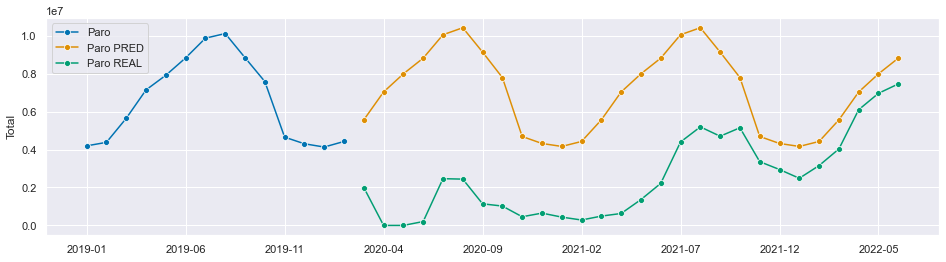

In [25]:
plot_series(y_train["2019":], turismo_pred,y_test, labels=["Paro", "Paro PRED", "Paro REAL"]);

La predicción por ETS, a simple vista, no predice en absoluto el momento COVID, pero a partir de después del verano del 2021 sí que afina más su precisión. Vamos a calcular el error de las predicciones mediante el RMSE y MAPE. 

In [66]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, turismo_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, turismo_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un RMSE de: 5171206.18
El modelo ETS genera un MAPE de: 2.4176054366296373e+23%


### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria en media ni en varianza, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, aplicaremos logaritmo y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

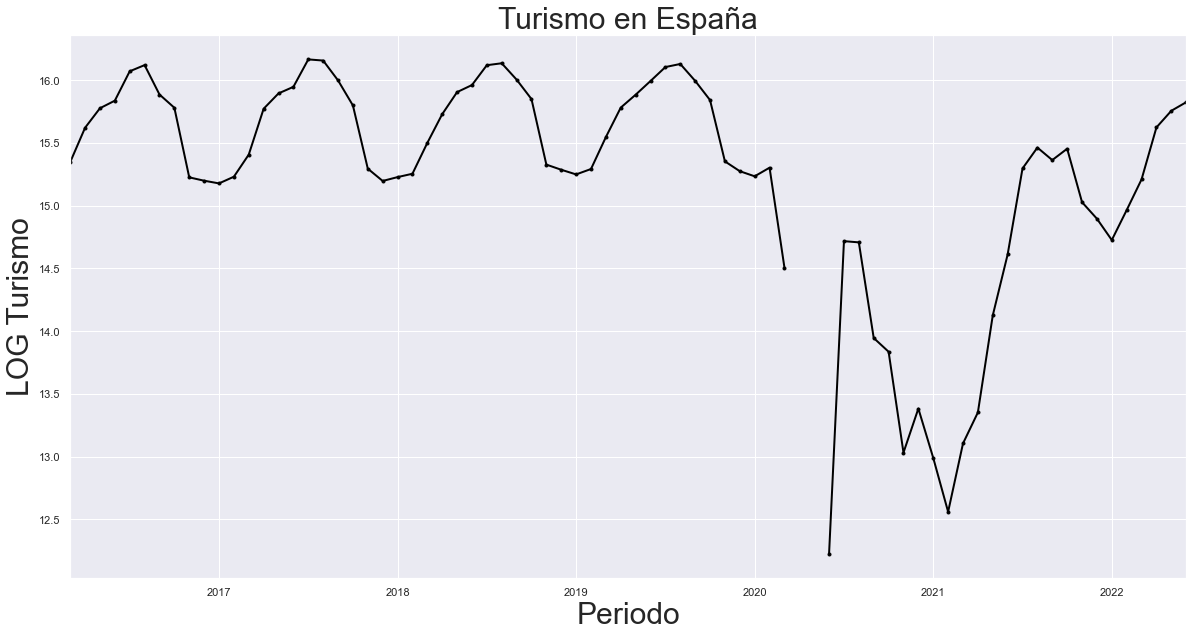

In [67]:
transformer = LogTransformer()
log_df_turismo= transformer.fit_transform(df_turismo['Total'])

# Representación 
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_turismo.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Turismo en España', fontsize = 30) 
fig.set_ylabel('LOG Turismo', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y test a la serie transformada en logs:

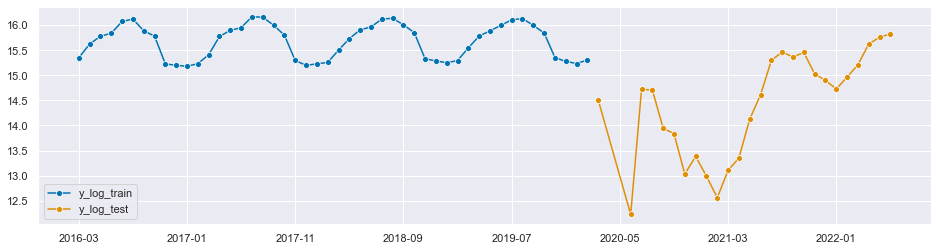

In [30]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_turismo.astype('float64').to_period('M').sort_index(),test_size=28)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
y_log_train.shape[0], y_log_test.shape[0];

Generamos el modelo y se entrena con los datos del train:

In [68]:
fh = np.arange(1,y_log_test.shape[0]+1)
turismo_auto_arima=AutoARIMA(d=1,D=1,sp=12,suppress_warnings=True)

turismo_auto_arima.fit(y_log_train)
turismo_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  63.902
Date:                            Mon, 05 Sep 2022   AIC                           -123.805
Time:                                    19:16:46   BIC                           -120.694
Sample:                                         0   HQIC                          -122.731
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6818      0.143     -4.760      0.000      -0.963      -0.401
sigma2         0.0015      0.000      3.187      0.001       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.68   Prob(JB):                         0.72
Heteroskedasticity (H):               0.47   Skew:                            -0.13
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
turismo_log_pred = turismo_auto_arima.predict(fh)
np.exp(turismo_log_pred).tail()

2022-02    4.429835e+06
2022-03    5.613064e+06
2022-04    7.185963e+06
2022-05    7.898263e+06
2022-06    8.860051e+06
Freq: M, dtype: float64

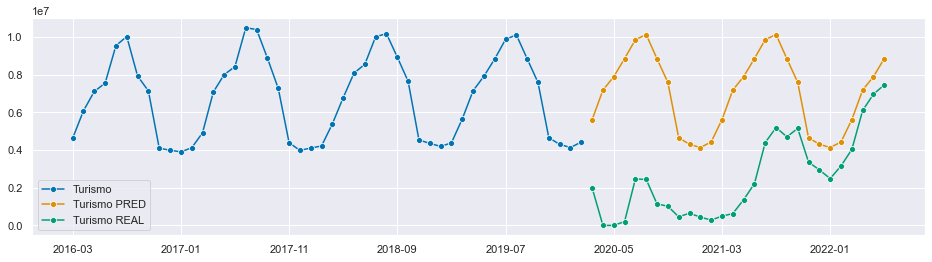

In [70]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(turismo_log_pred), np.exp(y_log_test), 
            labels=["Turismo", "Turismo PRED", "Turismo REAL"]);

In [35]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(turismo_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(turismo_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un RMSE de: 5097918.39


#### Una comparativa entre ETS y ARIMA

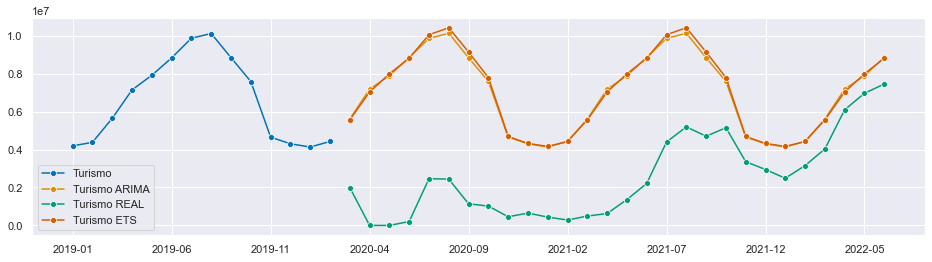

In [37]:
plot_series(np.exp(y_log_train["2019":]), np.exp(turismo_log_pred), np.exp(y_log_test), turismo_pred, 
            labels=["Turismo", "Turismo ARIMA", "Turismo REAL", 'Turismo ETS']);
# plt.savefig('../pics/df_turismo/etsarima.png')

Vemos que donde más se aproxima la predicción es a partir del mes de noviembre del 2021, lo cual nos serviría para la intervención que le haremos más adelante.
Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [71]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un RMSE de: 5171206.18
El modelo ARIMA genera un RMSE de: 5097918.39
El modelo ETS genera un MAPE de: 2.4176054366296373e+23%
El modelo ARIMA genera un MAPE de 2.425068498425092e+23%


### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [40]:
prophet_train = df_turismo.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [41]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

48

In [42]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

28

19:17:28 - cmdstanpy - INFO - Chain [1] start processing
19:17:29 - cmdstanpy - INFO - Chain [1] done processing


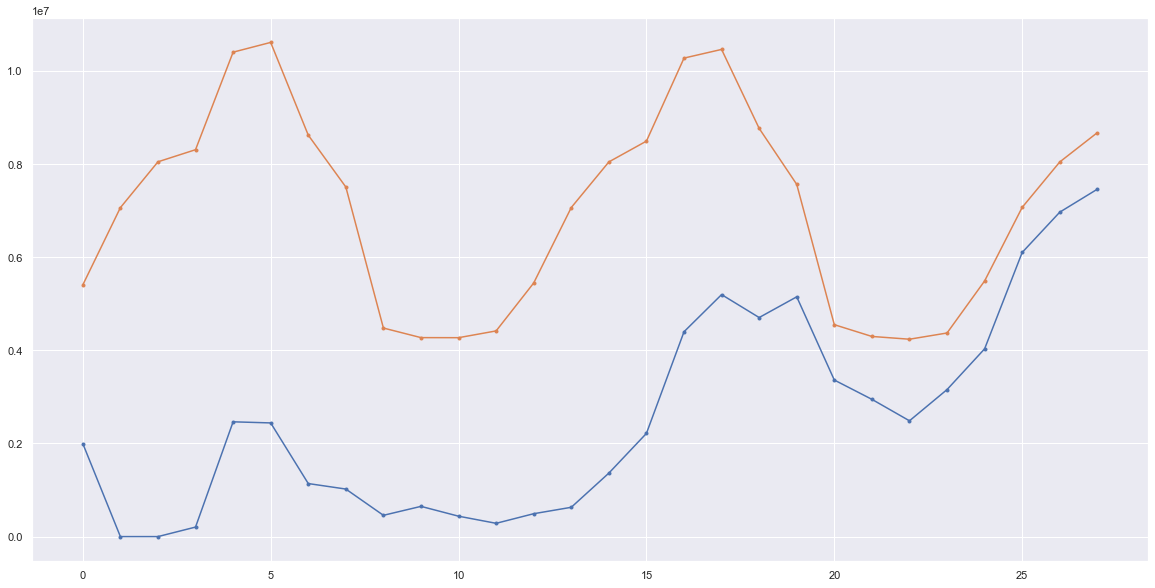

In [72]:
m = Prophet()
m.fit(prophet_y_train)

m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[48:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_turismo/prophet.png')

In [73]:
# Forecast Accuracy
# MAPE
mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[48:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[48:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un MAPE de: 2.4306095122170325e+23%
El modelo Prophet genera un RMSE de: 5102333.88


In [50]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
71,2022-02-28,4372073.0,4098220.0,4617440.0
72,2022-03-31,5489681.0,5222679.0,5741949.0
73,2022-04-30,7070222.0,6786727.0,7354471.0
74,2022-05-31,8045171.0,7758327.0,8322604.0
75,2022-06-30,8674301.0,8377390.0,8965156.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [51]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 5171206.18
El modelo ARIMA genera un RMSE de: 5097918.39
El modelo Prophet genera un RMSE de: 5102333.88


2) MAPE (Error porcentual)

In [52]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet,2)))

El modelo ETS genera un MAPE de: 2.4176054366296374e+21%
El modelo ARIMA genera un MAPE de 2.425068498425092e+21%
El modelo Prophet genera un MAPE de 2.430609512217033e+21%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es la ETS**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da, aunque el error es bastante elevado.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo hasta finales de año, es decir, hasta diciembre del 2022. 

In [53]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 7)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_turismo.astype('float64').to_period('M')
autoets_predict.fit(y)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [54]:
print(autoets_predict.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   76
Model:                      ETS(AAdA)   Log Likelihood               -1159.053
Date:                Mon, 05 Sep 2022   AIC                           2356.105
Time:                        18:57:32   BIC                           2400.389
Sample:                    03-31-2016   HQIC                          2373.803
                         - 06-30-2022   Scale                1033016816821.304
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9459      0.228      4.142      0.000       0.498       1.393
smoothing_trend         0.9458      0.348      2.719      0.007       0.264       1.628
smoothing_season

In [57]:
# Predicción del desempleo para los próximos 6 meses:
turismo_pred = autoets_predict.predict(fh=list(fh))
turismo_pred.round()

,Total
2022-07,10457316.0
2022-08,12292119.0
2022-09,13259977.0
2022-10,13966227.0
2022-11,12280633.0
2022-12,11972648.0


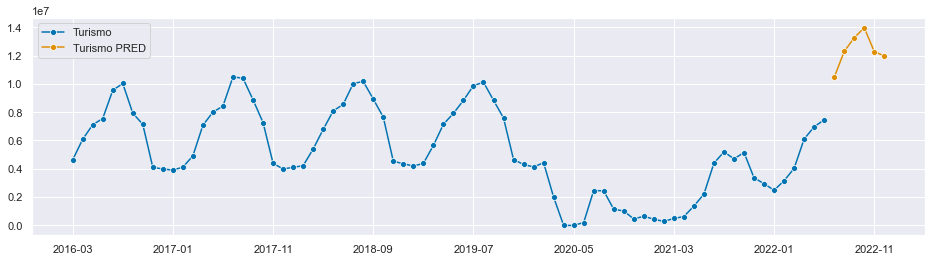

In [58]:
# Representamos gráficamente:
plot_series(y, turismo_pred, labels=["Turismo", "Turismo PRED"])
plt.show()
# plt.savefig('../pics/df_paro/predict2022.png')

In [61]:
# Guardado de datos a fichero CSV
turismo_pred.to_csv('../predictions/turismo.csv')

A continuación, en el Notebook "df_turismo_new" realizaremos una intervención quitando el momento COVID-19 para comprobar cuánta de diferencia hay en la precisión de la predicción cuando no hay un momento atípico.